In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import time


## VS Code, choisir un seul des 3 :

# Pour affichage interactif (notamment 3D) dans notebook
# %matplotlib widget

# Pour affichage interactif (notamment 3D) dans une fenêtre qt externe au notebook
# %matplotlib qt

# Pour affichage simple dans notebook
%config InlineBackend.figure_format = 'png'

In [2]:
df = pd.read_csv('data/df_train.csv')
df.columns

Index(['Unnamed: 0', 'day', 'hashed_partner_id', 'hashed_campaign_id',
       'contextid', 'display_env', 'target_env', 'rtbtypeid',
       'rtbadvisibility', 'rtb_detectedlanguage', 'urlhash2', 'urlhash3',
       'urlhash4', 'user_country', 'hashed_affiliateid', 'hashed_app_id',
       'googleviewability', 'googlepagevertical', 'campaignscenario',
       'campaignvertical', 'campaignctrlast24h', 'is_interstitial',
       'dayssincelastvisitdouble', 'ltf_lastpartnerclicktimestamp',
       'ltf_nbglobalclick_4w', 'ltf_nbglobaldisplay_4w',
       'ltf_nbglobaldisplaysincelastpartnerproductview',
       'ltf_nbpartnerdisplayssincelastclick', 'ltf_nbpartnerclick_4w',
       'ltf_nbpartnerdisplay_4w', 'ltf_nbpartnersales_4w',
       'ltf_nbpartnerdisplay_90d', 'ltf_nbpartnerclick_90d',
       'ltf_nbpartnersales_90d', 'nbdayssincelastclick', 'nbdisplay_1hour',
       'nbdisplaypartnerapprox_1d_sum_xdevice',
       'nbdisplayaffiliateapprox_1d_sum_xdevice',
       'nbdisplayglobalapprox_1d_s

In [3]:
# Recodage de certaines modalités afin de réordonner par ordre croissant d'engagement
df["contextid"] = df["contextid"].replace(0,1)
df["contextid"] = df["contextid"].replace(10,3)

In [4]:
# Remplacement des valeurs manquantes par des 0 dans les variables commençant par ltf
df['ltf_lastpartnerclicktimestamp'] = df['ltf_lastpartnerclicktimestamp'].fillna(0)
df['ltf_nbglobalclick_4w'] = df['ltf_nbglobalclick_4w'].fillna(0)
df['ltf_nbglobaldisplay_4w'] = df['ltf_nbglobaldisplay_4w'].fillna(0)
df['ltf_nbglobaldisplaysincelastpartnerproductview'] = df['ltf_nbglobaldisplaysincelastpartnerproductview'].fillna(0)
df['ltf_nbpartnerdisplayssincelastclick'] = df['ltf_nbpartnerdisplayssincelastclick'].fillna(0)
df['ltf_nbpartnerclick_4w'] = df['ltf_nbpartnerclick_4w'].fillna(0)
df['ltf_nbpartnerdisplay_4w'] = df['ltf_nbpartnerdisplay_4w'].fillna(0)
df['ltf_nbpartnersales_4w'] = df['ltf_nbpartnersales_4w'].fillna(0)
df['ltf_nbpartnerdisplay_90d'] = df['ltf_nbpartnerdisplay_90d'].fillna(0)
df['ltf_nbpartnerclick_90d'] = df['ltf_nbpartnerclick_90d'].fillna(0)
df['ltf_nbpartnersales_90d'] = df['ltf_nbpartnersales_90d'].fillna(0)

In [5]:
# Suppression de l'utilisateur cliquant un nombre abérant de fois
df.drop(df.index[df['hashed_xd_id'] == r"b'\x12\xb97|\xbe~\\\x94\xe8\xa7\r\x9d#\x92\x95#\xd1J\xfa\x95G\x93\x13\x0f\x8a9Y\xc7\xb8I\xac\xa8'"], inplace = True)

In [6]:
# Les nombres de clics ne sont plus abérants
b = df[['is_display_clicked', 'hashed_xd_id']].groupby(['hashed_xd_id']).sum()
b.sort_values('is_display_clicked', ascending=False)

,is_display_clicked
hashed_xd_id,
b'\x97\x9d)\xb3*\x8e\xf6\xeer\xf7\x166a\x12\xcc\xa5\xf4\x90\xc9\xd9\x197\xd1\xdf\x17f\x10%\xfe\x99\xe4\xb1',10
"b""L\xf5H\x97\x10\xfd\x7f~\x1a9\xa3?\xac\xfdNf\xf6\\\x8f13\xc1\xcc\xf8\xbf\xc9q\x87'\xbc]H""",10
b'\xc4\xc8\xb7\xb0\x7faU\x01D5\xfe\x96\xb7\x165\xff\x90\xc2\xcd;\xbf^\\\x10\xf9z*\x0e\xc6%4v',9
b'\xadk\x10\x99k\\\x7f\xef\xf3\x86\xe6f\\{)\xd8\x14t\x8b\x8b\x16\x7f\xb0z)\xd4\n\xe7&dN\xe9',9
b'>\x90\xdd\x05s\xf2\x8a\x1dv\xc8Kdy\xbc\xd9\xe7a+\xf6\x04G2\xed\x1eT\xe6\xaeS\x81L$\x9c',9
...,...
b'\x05\xa3\x85\xf7TeZ\x98\xcc&\x15\xdc\xbaY\x85\xe8\xf3\xce\xd2I\xc8R:;-\x1f\xb9\xb9\x9e\xef\x89\x95',0
"b'\x05\xa3\x99\xafx4\x96,G\xca\x03I\x97C|\xe7~\xad\x1d\x80M\x96[\xf0\xbd\x886\x96\x1c\xb8\x9c\xa9'",0
b'\x05\xa3\xaa?\xa0W\xf5\xc2\xf4\xcev~X\xe6\xfc\xb3%\xc8?;T\xff\xc1\x02\xf5\\k\xcb2N[\n',0


In [7]:
# Shuffling
df = df.sample(frac=1).reset_index(drop=True)

In [8]:
# Variables avec valeurs manquantes
pd.DataFrame({"Valeurs manquantes":df[df.columns[df.isnull().sum() != 0]].isnull().sum(), "Proportion manquante":df[df.columns[df.isnull().sum() != 0]].isnull().sum()/len(df)})

,Valeurs manquantes,Proportion manquante
rtbtypeid,6911,0.004291
rtbadvisibility,6911,0.004291
rtb_detectedlanguage,6911,0.004291
urlhash2,150948,0.093728
urlhash3,150948,0.093728
urlhash4,150948,0.093728
user_country,257,0.000160
hashed_app_id,605846,0.376186
googleviewability,1108837,0.688507
googlepagevertical,6911,0.004291


In [9]:
df['display_size'] = df['display_width']*df['display_height']

In [10]:
df_acp = df[['contextid','campaignctrlast24h','dayssincelastvisitdouble','nbdayssincelastclick','nbdisplayglobalapprox_1d_sum_xdevice','valueperclick','display_size','zonecostineuro', 'ltf_lastpartnerclicktimestamp','ltf_nbglobalclick_4w','ltf_nbglobaldisplay_4w','ltf_nbglobaldisplaysincelastpartnerproductview','ltf_nbpartnerdisplayssincelastclick','ltf_nbpartnerclick_4w','ltf_nbpartnerdisplay_4w','ltf_nbpartnersales_4w','ltf_nbpartnerdisplay_90d','ltf_nbpartnerclick_90d','ltf_nbpartnersales_90d', 'is_display_clicked']]
df_acp = df_acp.dropna().reset_index(drop=True)

In [11]:
colors = np.array(['r' if (df_acp['is_display_clicked'][i] == 0) else 'g' for i in range(len(df_acp))])
df_acp = df_acp.drop(['is_display_clicked'], axis=1)

In [12]:
len(df_acp)/len(df)

0.9742886344190044

In [13]:
sc = StandardScaler()
Z = sc.fit_transform(df_acp)
Z

array([[ 0.1495114 ,  0.62130541, -0.3689221 , ..., -0.0733187 ,
        -0.03405711, -0.01384723],
       [ 0.97583237, -0.96507491, -0.38530021, ..., -0.0733187 ,
        -0.03405711, -0.01384723],
       [ 1.38899285,  1.3729995 , -0.3318528 , ..., -0.0733187 ,
        -0.03405711, -0.01384723],
       ...,
       [ 1.38899285,  1.86703217, -0.38601905, ..., -0.0733187 ,
        -0.03405711, -0.01384723],
       [ 0.56267188, -0.53516626,  0.09162705, ..., -0.0733187 ,
        -0.03405711, -0.01384723],
       [ 0.1495114 , -0.94059539,  0.48270041, ..., -0.0733187 ,
        -0.03405711, -0.01384723]])

In [14]:
acp = PCA(svd_solver='full')

In [15]:
# Calcul des coordonnées factorielles
coord = acp.fit_transform(Z)
# Vérification du nombre de composantes principales
print(acp.n_components_)

19


In [16]:
print(acp.explained_variance_ratio_)

[0.24776359 0.10372374 0.08709018 0.08079353 0.06902535 0.06324157
 0.05392185 0.05258037 0.04308959 0.04209165 0.03743847 0.03106963
 0.02711964 0.01997004 0.01584643 0.01173447 0.00624026 0.00489978
 0.00235987]


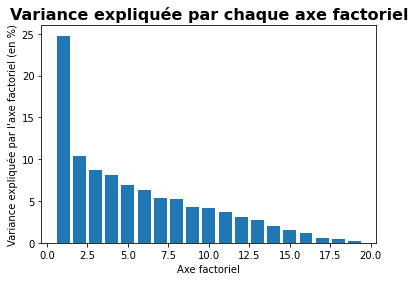

In [17]:
plt.figure(figsize=(6,4))
plt.bar(np.arange(1,acp.n_components_+1),acp.explained_variance_ratio_*100)
plt.title("Variance expliquée par chaque axe factoriel", size=16, fontweight='bold')
plt.ylabel("Variance expliquée par l'axe factoriel (en %)", size=10)
plt.xlabel("Axe factoriel", size=10)
plt.show()

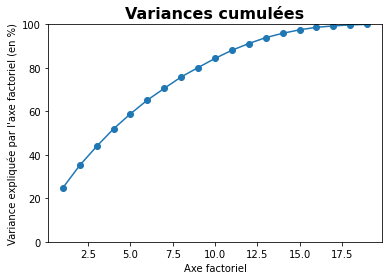

In [18]:
plt.figure(figsize=(6,4))
plt.plot(np.arange(1,acp.n_components_+1),acp.explained_variance_ratio_.cumsum()*100,  marker = 'o')
plt.title("Variances cumulées", size=16, fontweight='bold')
plt.ylim(0, 100)
plt.ylabel("Variance expliquée par l'axe factoriel (en %)", size=10)
plt.xlabel("Axe factoriel", size=10)
plt.show()

In [19]:
#coord_not_cliqued = [ [] for _ in range(acp.n_components_)]
#coord_cliqued = [ [] for _ in range(acp.n_components_)]

#for i in range(len(coord[:,0])):
#    if df['is_display_clicked'][i] == 0:
#        for j in range(acp.n_components_):
#            coord_not_cliqued[j].append(coord[i,j])
#    else:
#        for j in range(acp.n_components_):
#            coord_cliqued[j].append(coord[i,j])

In [20]:
#def affichage_plan_factoriel(i, j, pourcentage=1, equal=False, markersize=0.75, verbose=False):
#    """
#    pourcentage: proprotion de points à afficher
#    equal: si True, autant de points rouges que de points verts
#    """
#    plt.figure(figsize=(6,4))
#
#    if not equal:
#        N_not = int(1/pourcentage)
#        N = int(1/pourcentage)
#    
#
#    if equal:
#        coeff = len(coord_cliqued[0]) / len(coord_not_cliqued[0])
#
#        N_not = int(1/(pourcentage*coeff))
#        N = int(1/pourcentage)
#
#        # N_not = int(1/pourcentage)
#        # N = int(coeff/pourcentage)
#
#    if verbose:
#        print(f"N_not : {N_not}")
#        print(f"N : {N}")
#        print(f"Nombre de points rouges : {len(coord_not_cliqued[0][::N_not])}")
#        print(f"Nombre de points verts : {len(coord_cliqued[0][::N])}")
#
#    plt.plot(coord_not_cliqued[i-1][::N_not], coord_not_cliqued[j-1][::N_not], '.', color='r', #linestyle="None", markersize=markersize)
#    plt.plot(coord_cliqued[i-1][::N], coord_cliqued[j-1][::N], '.', color='g', linestyle="None", #markersize=markersize)
#    plt.xlabel(f'Axe {i}')
#    plt.ylabel(f'Axe {j}')
#    plt.title(f'Plan (Axe {i}, Axe {j})')
#    plt.legend(['Pas cliqué', 'Cliqué'])
#    # plt.savefig('plan_axe1_axe2.png', dpi = 500, bbox_inches='tight', figsize=(10,6))
#    # plt.close()
#    plt.show()

def affichage_plan_factoriel(i,j):
    plt.figure(figsize=(6,4))
    plt.xlabel(f'Axe {i}')
    plt.ylabel(f'Axe {j}')
    plt.title(f'Plan (Axe {i}, Axe {j})')
    plt.scatter(coord[:,i-1], coord[:,j-1], c=colors, marker=".", s=0.75)
    plt.show()

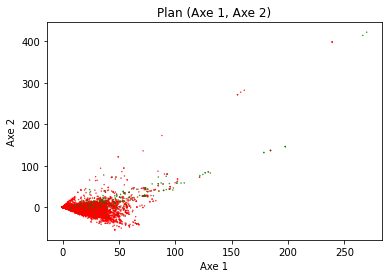

In [21]:
affichage_plan_factoriel(1, 2)

In [22]:
# On supprime les observations marginales
axe1 = np.array(coord[:,0])
df_acp.drop(df_acp.index[axe1 > 115], inplace=True)
colors = colors[axe1 <= 115]

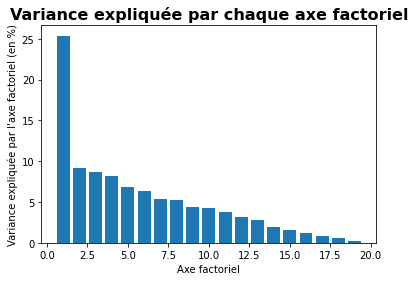

In [23]:
sc = StandardScaler()
Z = sc.fit_transform(df_acp)
acp = PCA(svd_solver='full')
coord = acp.fit_transform(Z)
plt.figure(figsize=(6,4))
plt.bar(np.arange(1,acp.n_components_+1),acp.explained_variance_ratio_*100)
plt.title("Variance expliquée par chaque axe factoriel", size=16, fontweight='bold')
plt.ylabel("Variance expliquée par l'axe factoriel (en %)", size=10)
plt.xlabel("Axe factoriel", size=10)
plt.show()

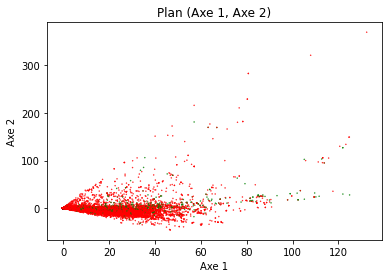

In [24]:
affichage_plan_factoriel(1, 2)

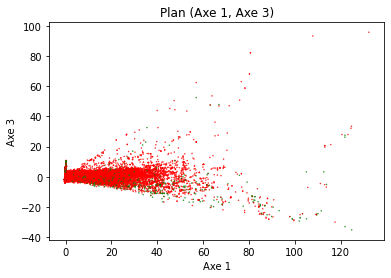

In [25]:
affichage_plan_factoriel(1, 3)

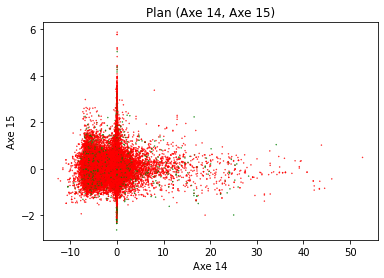

In [50]:
affichage_plan_factoriel(14,15)

In [26]:
n = len(df_acp)
p = len(df_acp.columns)

eigval = (n-1)/n*acp.explained_variance_
sqrt_eigval = np.sqrt(eigval)
corvar = np.zeros((p,p))
for k in range(p):
    corvar[:,k] = acp.components_[k,:] * sqrt_eigval[k]

In [27]:
def affichage_cercle_corr(ax1, ax2):
    fig, axes = plt.subplots(figsize=(5,5))
    axes.set_xlim(-1.05, 1.05)
    axes.set_ylim(-1.05, 1.05)

    for j in range(p):
        axes.arrow(0, 0, corvar[j,ax1], corvar[j,ax2], head_width=0.005, head_length=0.01, fc='grey', ec='grey')
        plt.annotate(df_acp.columns[j], (corvar[j,ax1],corvar[j,ax2]), size=8, color='r')

    plt.plot([-1, 1], [0, 0],color='silver', linestyle='-', linewidth=1)
    plt.plot([0, 0], [-1, 1],color='silver', linestyle='-', linewidth=1)

    cercle = plt.Circle((0, 0), 1, color='blue', fill=False)
    axes.add_artist(cercle)

    plt.show()

In [28]:
affichage_cercle_corr(1,2)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [29]:
affichage_cercle_corr(4,5)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [30]:
print(pd.Series(coord_cliqued[3]).describe(), '\n')
print(pd.Series(coord_not_cliqued[3]).describe())

count    80294.000000
mean        -0.000088
std          1.209410
min        -80.700510
25%         -0.111405
50%          0.009653
75%          0.107072
max        177.459861
dtype: float64 

count    1.329469e+06
mean     5.291067e-06
std      1.231301e+00
min     -1.995335e+02
25%     -1.116810e-01
50%      1.112707e-02
75%      1.078602e-01
max      3.628026e+02
dtype: float64


In [31]:
plt.figure(figsize=(6,6))
plt.rc('xtick', labelsize=5)
plt.xticks(rotation=45)
plt.bar(np.arange(1,acp.n_components_+1), corvar[:,4], tick_label=df_acp.columns)
plt.title("Corrélations sur l'axe 4", size=16, fontweight='bold')
plt.ylabel("Corr(Variable, Axe factoriel 4)", size=10)
plt.xlabel("Variable", size=10)
plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [32]:
def affichage_3d_factoriel(i, j, k, pourcentage=1, equal=False, markersize=1, verbose=False):
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')
    
    if not equal:
        N_not = int(1/pourcentage)
        N = int(1/pourcentage)
    
    if equal:
        coeff = len(coord_cliqued[0]) / len(coord_not_cliqued[0])

        N_not = int(1/(pourcentage*coeff))
        N = int(1/pourcentage)

        # N_not = int(1/pourcentage)
        # N = int(coeff/pourcentage)

    if verbose:
        print(f"N_not : {N_not}")
        print(f"N : {N}")
        print(f"Nombre de points rouges : {len(coord_not_cliqued[0][::N_not])}")
        print(f"Nombre de points verts : {len(coord_cliqued[0][::N])}")

    ax.scatter(coord_not_cliqued[i-1][::N_not], coord_not_cliqued[j-1][::N_not], coord_not_cliqued[k-1][::N_not], s=markersize, color='r', linestyle="None", marker='o')
    ax.scatter(coord_cliqued[i-1][::N], coord_cliqued[j-1][::N], coord_cliqued[k-1][::N], s=markersize, color='g', linestyle="None", marker='o')
    ax.set_xlabel(f'Axe {i}')
    ax.set_ylabel(f'Axe {j}')
    ax.set_zlabel(f'Axe {k}')
    plt.title(f'Plan (Axe {i}, Axe {j}, Axe {k})')
    plt.legend(['Pas cliqué', 'Cliqué'])
    plt.show()

In [33]:
affichage_3d_factoriel(1, 2, 3, pourcentage=0.01, equal=True, markersize=5, verbose=True)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

N_not : 1655
N : 100
Nombre de points rouges : 804
Nombre de points verts : 803
